In [41]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib as plt
import numpy as np
import matplotlib.pyplot as plt
import random

In [42]:
np.random.seed(69)
torch.manual_seed(69)
random.seed(69)

class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return img


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        label = F.one_hot(torch.tensor(label), num_classes=2).squeeze().to(torch.float32)
        return image, label

In [43]:
with open('test/image_list.txt', 'r') as f:
    lines = f.readlines()

        # Créer des listes pour stocker les chemins d'image et les étiquettes
    image_paths = []
    labels = []

        # Parcourir chaque ligne du fichier texte et extraire les informations
    for line in lines:
        line = line.strip().split(' ')
        if line[1] == "0"  or line[1] == "1":
                
            image_paths.append("test/" + line[0])
            
            labels.append(int(line[1]))
        # Appliquer les transformations d'image si nécessaire
    transformation = transforms.Compose([
        ConvertToRGB(),
        transforms.Resize(256), 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    df_test = CustomDataset(image_paths, labels, transform=transformation)
    testloader = DataLoader(df_test, batch_size=1, shuffle=True)

In [44]:
def extrait_batch(loader):

    # Récupérer le premier batch d'images et d'étiquettes
    images, labels = next(iter(loader))

    # Boucler sur chaque image du batch
    for i in range(len(images)):
        image = images[i]

        # Convertir le tenseur d'image en ndarray
        image_np = image.permute(1, 2, 0).numpy()

        # Afficher l'image
        plt.imshow(image_np)
        plt.axis('off')  # Enlever les axes
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


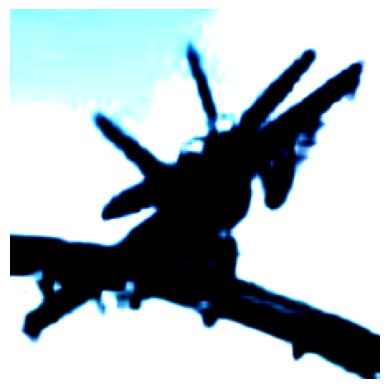

In [45]:
extrait_batch(loader = testloader)

In [ ]:
def model():
    pass

class Stratégie():

    def __init__(self, budget, n):
        # initialiser les quantités
        self.budget = budget
        self.counter = [0]*n #nombre de classe

    def reset(self):
        # reset les compteurs, etc
        self.counter = [0]*self.n

    def get_action(self, yt):
            # procédure de sélection d'une action
            if self.counter[yt]< self.budget:
                return 1
            else:
                return 0
    
    def update(self, yt):
        #mettre a jour les compteurs 
        self.counter[yt] += 1

In [ ]:
def train(dataloader, model, criterion, device, optimizer=None, is_training=False):

    loss_list = []
    total_samples = 0
    correct_predictions = 0

    if is_training:
        model.train()
    else:
        model.eval()

    with torch.set_grad_enabled(is_training):
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # forward pass
            output = model(images)
            loss = criterion(output, labels)
            loss_list.append(loss.item())  # Ajouter la perte actuelle à la liste

            total_samples += images.size(0)  # Accumuler le nombre total d'échantillons

            labels_ = torch.argmax(labels, dim=1)
            predicted = torch.argmax(output, dim=1)
            correct_predictions += (predicted == labels_).sum().item()  # Accumuler le nombre de prédictions correctes

            if is_training:
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
                # update weights
                optimizer.step()

    mean_loss = torch.tensor(loss_list).mean().item()
    mean_accuracy = (100.0 * correct_predictions) / total_samples
    return mean_loss, mean_accuracy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


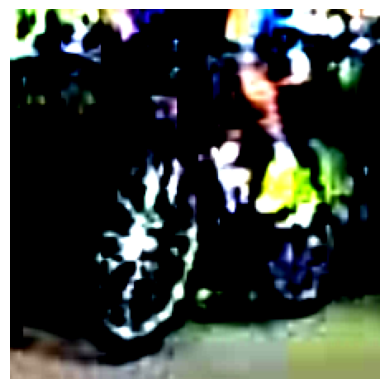

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


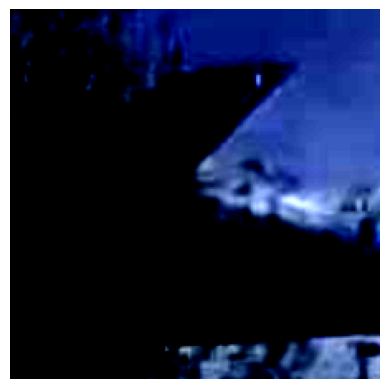

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


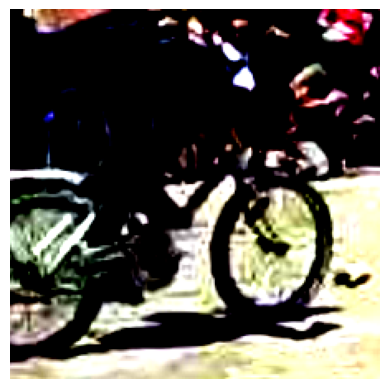

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


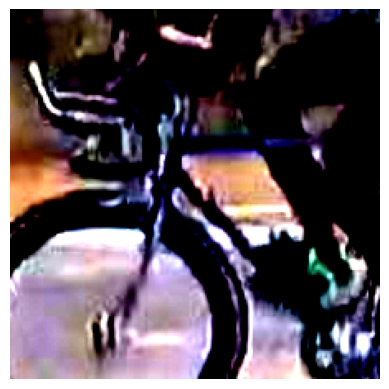

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


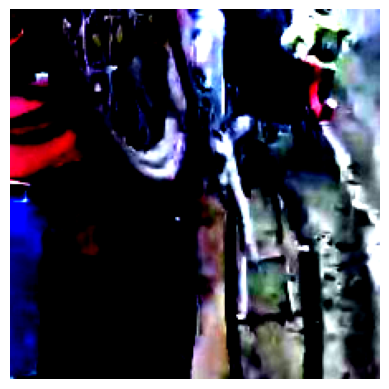

In [46]:
total, correct = 0.0, 0.0
budget = 1000
n = 0
device = torch.device("cuda")
strategy = Stratégie(budget = budget)
strategy.reset()
for inputs, labels in testloader: #Faut split
    inputs = inputs.to(device)
    strategy.update()  
    output = model(inputs)
    if strategy.get_action(output) == 1: #dévoiler le label
            labels = labels.to(device) #rajouter un couple (x,y) x input y label
            #Ajouter le couple xy a une bdd 
            #Reset le model avec la sauvegarde pth
            #reentrainer le modele a partir de cette sauvegarde sur la bdd maj (avec une nouvelle obs)
            #prochaine étape buffer faire toutes les 50 nouvelles obs
            train()